In [556]:
import os, sys
import pandas as pd
import geopandas as gpd
import pylab as pl
import seaborn as sns
import numpy as np
import requests
import zipfile as zf
from google.transit import gtfs_realtime_pb2 as gtfs
import json
import lzmaffi as lzma
import shutil
import shapely.geometry as geom
from shapely.geometry import Point
import pyproj

% pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/shay/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['dist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
# data string in YYYYMMDD format
def bustimedl(date): 
    ''' 
    takes date string in YYYYMMDD format and downloads bus time data
    '''
    
    yr = date[:4]
    mnth = date[4:6]

    fn = 'bus_time_' + date + '.csv'

    if os.path.exists('data/' + fn + '.xz'): 
        print 'Already downloaded'
    else: 
        baseurl = 'http://data.mytransit.nyc/bus_time/' 
        url = baseurl + yr + '/' + yr + '-' + mnth + '/' + fn + '.xz'
        r = requests.get(url)
        with open(fn + '.xz', 'wb') as f: 
            f.write(r.content)
            f.close()
        shutil.move(fn + '.xz', 'data')

In [63]:
def create_one_line(date, route): 
    ''' 
    create csv for just one route'''
    fn = 'bus_time_' + date + '.csv'
    colnames = ['timestamp', 'vehicle_id', 'latitude', 'longitude', 'bearing',
                'progress', 'service_date', 'trip_id', 'block_assigned',
                 'next_stop_id', 'dist_along_route', 'dist_from_stop']
    try: 
        df = pd.read_csv(fn, header=None, names=colnames)
    except:
        with lzma.open('data/' + fn + '.xz') as lz: 
            with open(fn, 'wb') as fi:
                for line in lz: 
                    if '_' + route + '_' in line: 
                        fi.write(line)
            fi.close()
        lz.close()
        df = pd.read_csv(fn, header=None, names=colnames)
    return df

In [51]:
days = np.linspace(17, 28, 12)
dates = ['201704' + str(int(day)) for day in days]

In [64]:
b35 = pd.DataFrame()
for date in dates:
    bustimedl(date)
    temp = create_one_line(date, 'B35')
    b35 = b35.append(temp)

Already downloaded


/Users/shay/anaconda2/lib/python2.7/site-packages/lzmaffi/_lzmamodule2.py:348: UserWarning: implicit cast from 'char *' to a different pointer type: will be forbidden in the future (check that the types are as you expect; use an explicit ffi.cast() if they are correct)
  lzret = fun(*args)
/Users/shay/anaconda2/lib/python2.7/site-packages/lzmaffi/_lzmamodule2.py:733: UserWarning: implicit cast from 'char *' to a different pointer type: will be forbidden in the future (check that the types are as you expect; use an explicit ffi.cast() if they are correct)
  lzs.next_in = in_ = ffi.new('char[]', data)


Already downloaded
Already downloaded
Already downloaded
Already downloaded
Already downloaded
Already downloaded
Already downloaded
Already downloaded
Already downloaded
Already downloaded
Already downloaded


In [70]:
b35.timestamp = pd.to_datetime(b35.timestamp)

In [71]:
b35['geometry'] = [Point(xy) for xy in zip(b35.longitude, b35.latitude)]

In [72]:
b35 = gpd.GeoDataFrame(b35)

In [9]:
#that is not what the bus route looks like...

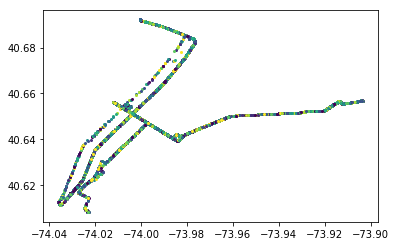

In [10]:
b35.plot()

In [73]:
import geocoder

In [74]:
# collect rough geocoordinates of intersections of interest
mcdonald_inter = geocoder.google('McDonald Ave and Church Ave, Brooklyn')
e18_inter = geocoder.google('E 18 and Church Ave, Brooklyn')

In [75]:
e18_inter.latlng

[40.6494523, -73.9630634]

In [76]:
x = (e18_inter.lng, mcdonald_inter.lng)
y = (e18_inter.lat, mcdonald_inter.lat)
boundary = geom.geo.box(min(x), min(y), max(x), max(y))

In [109]:
b35_ofinterest = b35[b35.within(boundary)]


In [320]:
b35_ofinterest['weekday'] = b35_ofinterest.timestamp.apply(lambda x: x.weekday())
b35_ofinterest = b35_ofinterest[b35_ofinterest.weekday < 5]
b35_ofinterest = b35_ofinterest[b35_ofinterest.bearing > 30]

/Users/shay/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


array([0, 1, 2, 3, 4])

In [78]:
from fiona.crs import from_epsg

In [110]:
b35_ofinterest.crs = from_epsg(4326)
b35_ofinterest = b35_ofinterest.to_crs(epsg = 2263)

In [82]:
proj = pyproj.Proj(init="epsg:2263", preserve_units=True)
mcdonald = Point(proj(mcdonald_inter.lng, mcdonald_inter.lat))
e18 = Point(proj(e18_inter.lng, e18_inter.lat))

In [250]:
routedist = e18.distance(mcdonald) * 0.0003048 # convert foot distance to km

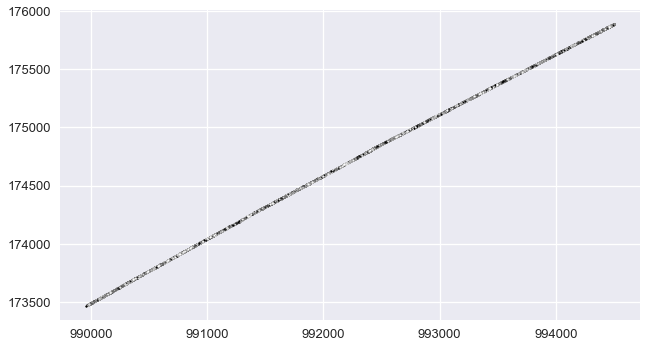

In [572]:
b35_ofinterest.plot()

In [681]:
def calcTimeDis(df): 
    '''
    takes df
    sorts by trip id and time
    westward only
    returns numpy array of difference in distance between first and last gps ping (in meters)
    returns numpy array of difference in time between first and last gps ping (in minutes)
    '''
    triplen_west = []
    timelen_west = []
    for trip in df.uniqueid.unique():
        temp_df = df[df.uniqueid == trip]
        temp_df = temp_df.sort_values('timestamp')
        if len(temp_df) > 4:        
            
            dist1 = temp_df.geometry.iloc[0]
            time1 = temp_df.timestamp.iloc[0]
            dist2 = temp_df.geometry.iloc[len(temp_df)-1]
            time2 = temp_df.timestamp.iloc[len(temp_df)-1]
            timedelta = time2 - time1
            distance = dist1.distance(dist2) * .0003048
            if distance > 0: 
                triplen_west.append(distance)
                timelen_west.append(timedelta.seconds * 60) 
    return np.array(triplen_west), np.array(timelen_west)

In [209]:
# compute weighted avg for time taken to travese the route
# therefore length/time (feet per minute)

In [323]:
b35_ofinterest['uniqueid'] = [str(x) for x in b35_ofinterest.service_date] + b35_ofinterest.trip_id

In [678]:
calcTimeDis(b35_ofinterest)

2017-04-17 00:06:52
2017-04-17 00:02:04
0 days 00:04:48


(array([], dtype=float64), array([], dtype=float64))

In [520]:
def nonlinearmod(dens, tm_est = 7/5, station = 7, length = routedist): 
    '''
    Normal Conditions Bus Delay Model (Non-Linear) - 
    
    Takes estimated traffic density
    length: (kilometers)
    station: number of bus stops on length
    estimated total time / moving time 
   

    '''

    x1 = 5.722 * (10**.07) * (dens**3)
    x2 = .3709 * (length**3)
    x3 = .1174 * (station**2)
    x4 = 0.08 * tm_est
    return 0.1403 + x1 + x2 + x3 + x4

In [521]:
def linearmod(densl, denst, mt_est = 5/7, length = routedist, station = 7): 
    '''
    Normal Conditions Bus Delay Model (Linear) 
    Takes estimated traffic density - left hand turn
    estimated traffic density - through traffic
    estimated moving time / total time 
    length in kilometers 
    and number of stations 
    '''
    x1 = 0.0287 * densl
    x2 = 0.0168 * denst
    x3 = .9654 * length
    x4 = -1.1969 * mt_est
    x5 = .1130 * station
    return 0.4855 + x1 + x2 + x3 + x4 + x5

In [324]:
b35_ofinterest['hour'] = b35_ofinterest.timestamp.apply(lambda x: x.hour)

In [325]:
b35_ofinterest.head()

,timestamp,vehicle_id,latitude,longitude,bearing,progress,service_date,trip_id,block_assigned,next_stop_id,dist_along_route,dist_from_stop,geometry,hour,uniqueid,weekday
7,2017-04-17 00:00:13,414,40.646038,-73.971654,202.67,0,20170416,JG_B7-Sunday-115900_B35_49,1,302766,5908.66,171.84,POINT (992116.1640478717 174646.7154330283),0,20170416JG_B7-Sunday-115900_B35_49,0
23,2017-04-17 00:01:18,414,40.645464,-73.973068,202.13,0,20170416,JG_B7-Sunday-115900_B35_49,1,302766,5908.66,36.56,POINT (991723.8359212143 174437.467725515),0,20170416JG_B7-Sunday-115900_B35_49,0
27,2017-04-17 00:01:50,414,40.644467,-73.975469,202.64,0,20170416,JG_B7-Sunday-115900_B35_49,1,302767,6147.12,44.02,POINT (991057.6418027944 174074.0376643678),0,20170416JG_B7-Sunday-115900_B35_49,0
32,2017-04-17 00:02:04,444,40.649190,-73.963717,201.35,0,20170416,JG_B7-Sunday-116700_B35_39,1,302762,5121.4,140.43,POINT (994318.2475160047 175795.8879543969),0,20170416JG_B7-Sunday-116700_B35_39,0
43,2017-04-17 00:02:22,414,40.643739,-73.977208,202.79,0,20170416,JG_B7-Sunday-115900_B35_49,1,302768,6326.81,56.15,POINT (990575.1178159509 173808.6770428368),0,20170416JG_B7-Sunday-115900_B35_49,0


In [680]:
for hour in np.linspace(0, 23, 24): 
    b35_early = b35_ofinterest[b35_ofinterest.hour == hour]

    distn, time = calcTimeDis(b35_early)
    avgspeed = mean(distn / time * 60)
    avgtime = routedist / avgspeed * 60
    print hour, avgtime

TypeError: unsupported operand type(s) for /: 'float' and 'Timedelta'

In [682]:
# limit to only those trips with first gps ping within 100 feet of e18 and final
# within 100 feet of mcdonald
# between 9 and 10 am

def limitedDF(initialdf, hour):
    '''
    takes dataframe and hour of interest
    reduces dataframe to just that hour
    returns new dataframe with just those points where first point is within 100 feet of 
    e 18 and 2nd is within 100 feet of mcdonald'''
    
    unique = []
    date = []
    distance = []
    time = []
    
    df = initialdf[initialdf.hour == hour]
    e18buff = e18.buffer(200)
    mcdonbuff = mcdonald.buffer(200)
    for trip in df.uniqueid.unique():
        temp_df = df[df.uniqueid == trip]
        temp_df = temp_df.sort_values('timestamp')
        if temp_df.bearing.iloc[0] > 30: 
            dist1 = temp_df.geometry.iloc[0]
            dist2 = temp_df.geometry.iloc[len(temp_df)-1]
            time1 = temp_df.timestamp.iloc[0]
            time2 = temp_df.timestamp.iloc[len(temp_df)-1]
            timedelta = time2 - time1
            if dist1.distance(dist2) * .0003048 > .95 * routedist:
                unique.append(temp_df.uniqueid.iloc[0])
                date.append(temp_df.service_date.iloc[0])
                distance.append(dist1.distance(dist2) * .0003048)
                time.append(timedelta)
    resultsdf = pd.DataFrame({'uniqueid': unique,
                'date': date,
                'distance': distance,
                'time': time})
    return resultsdf

In [38]:
def calcVactual(actual, delays):
    distance = 1.569
    speedwodelays = 25 # kmph per paper
    calc = distance / speedwodelays + delays
    return actual - calc

In [683]:
acceptable = limitedDF(b35_ofinterest, 9)

In [700]:
acceptable.reset_index(inplace = True)

In [708]:
acceptable['timeminutes'] = [x.seconds / 60.0 for x in acceptable.time]

In [741]:
acceptable['time2'] = [acceptable.timeminutes[x] if acceptable.distance[x] == 1.569 else 
                       routedist/acceptable.distance[x] * acceptable.timeminutes[x] for x in acceptable.index]

In [744]:
acceptable.time2.d

count    11.000000
mean      8.497598
std       1.880669
min       5.968628
25%       6.857316
50%       8.709041
75%       9.943494
max      11.083333
Name: time2, dtype: float64

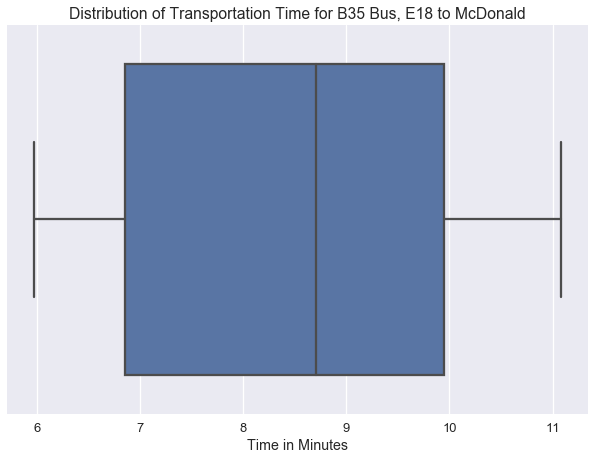

In [749]:
sns.boxplot(acceptable.time2)
pl.title('Distribution of Transportation Time for B35 Bus, E18 to McDonald')
pl.xlabel('Time in Minutes')
pl.savefig('Distribution.png')

In [645]:
personalobs = pd.read_csv('data/Bus Data - Sheet2.csv')

In [646]:
personalobs.time = personalobs.time * 60

In [647]:
personalobs.time = personalobs.time.apply(lambda x: int(x))
personalobs.time = personalobs.time.apply(lambda x: time(minute = x / 60, second = x % 60))

In [648]:
from datetime import date, datetime, time
timeobj = time(hour = 0)
personalobs.time = personalobs.time.apply(lambda x: datetime.combine(date.today(), x) 
                       - datetime.combine(date.today(), timeobj))


In [689]:
acceptable = acceptable.append(personalobs)

In [750]:
acceptable.time2.describe()

count    11.000000
mean      8.497598
std       1.880669
min       5.968628
25%       6.857316
50%       8.709041
75%       9.943494
max      11.083333
Name: time2, dtype: float64

In [650]:
# counts taken at Church Ave and Marlborough, 4/19, 4/21 and 4/26
car_counts = [32.0, 40.0, 34.0]

In [651]:
# assuming it takes 7 minute for them to clear

In [658]:
personalobs.time.mean()

Timedelta('0 days 00:09:32.800000')

In [417]:
densities = [x / routedist for x in car_counts]

In [524]:
densities

[20.386581266424027, 25.483226583030035, 21.66074259557553]

In [559]:
test_dens = np.arange(10, 55, 5)

In [662]:
personalobs.time.mean()

Timedelta('0 days 00:09:32.800000')

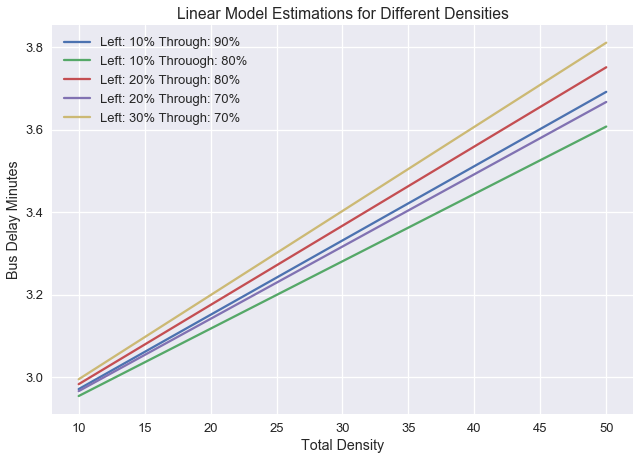

In [568]:
# run model for left hand turn density .1, through .9
sns.set_context('talk')
delayminutes = [linearmod(x * .1, x * .9) for x in test_dens]
delayminutes2 = [linearmod(x * .1, x * .8) for x in test_dens]
delayminutes3 = [linearmod(x * .2, x * .8) for x in test_dens]
delayminutes4 = [linearmod(x * .2, x * .7) for x in test_dens]
delayminutes5 = [linearmod(x * .3, x * .7) for x in test_dens]
pl.plot(test_dens, delayminutes, label = 'Left: 10% Through: 90%')
pl.plot(test_dens, delayminutes2, label = 'Left: 10% Throuogh: 80%')
pl.plot(test_dens, delayminutes3, label = 'Left: 20% Through: 80%')
pl.plot(test_dens, delayminutes4, label = 'Left: 20% Through: 70%')
pl.plot(test_dens, delayminutes5, label = 'Left: 30% Through: 70%')

pl.title('Linear Model Estimations for Different Densities')
pl.xlabel('Total Density')
pl.ylabel('Bus Delay Minutes')
pl.legend()
pl.savefig('linearmodel.png')

In [579]:
routedist / 25 * 60

3.767183864539704

In [607]:
timeobj = datetime.time(hour = 0)

In [657]:
distance

date        2.017042e+07
distance    1.525666e+00
dtype: float64